In [1]:
import torch
from methods.cgan import Generator, Discriminator
from robot import TwoLinkRobotIK

# Load the model
latent_size = 2
hidden_size = 64
output_size = 2
condition_size = 2

generator = Generator(latent_size, hidden_size, output_size, condition_size)
# generator.load_state_dict(torch.load('logs/cgan_model_gradient_data/cgan_model_gradient_data.pth', weights_only=True))
generator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/generator_gradient_data_rs.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_model_incremental_data/generator_incremental_data.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_training_replace/generator_4.pt', weights_only=True))
generator.eval()

discriminator = Discriminator(output_size, hidden_size, 1, condition_size)
discriminator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/discriminator_gradient_data_rs.pth', weights_only=True))

# Load the robot
# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)


# Visualize Discriminator

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming the classes TwoLinkRobotIK and Discriminator are already defined and imported

def plot_robot_and_heatmap(robot, discriminator, angles, grid_size=100):
    # Unpack angles
    theta1, theta2 = angles

    # Generate grid points within the workspace
    x_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    y_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

    # Compute discriminator output for each grid point
    discriminator_outputs = []
    for point in grid_points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        angles_tensor = torch.tensor(angles, dtype=torch.float32).unsqueeze(0)
        output = discriminator(angles_tensor, point_tensor).detach()
        discriminator_outputs.append(output.item())

    # Reshape the outputs to match the grid
    discriminator_outputs = np.array(discriminator_outputs).reshape(grid_size, grid_size)

    # Plot the robot and heatmap on the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(discriminator_outputs, extent=(x_range.min(), x_range.max(), y_range.min(), y_range.max()), origin='lower', cmap=cm.viridis, alpha=0.6)
    plt.colorbar(heatmap, ax=ax, label='Discriminator Output')

    # Plot the robot
    # Compute joint positions using numpy
    joint1 = (robot.link1_length * np.cos(theta1),
              robot.link1_length * np.sin(theta1))
    end_effector = (
        joint1[0] + robot.link2_length * np.cos(theta1 + theta2),
        joint1[1] + robot.link2_length * np.sin(theta1 + theta2),
    )

    # Plot the robot arm
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', color='black')
    ax.set_xlim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_ylim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_aspect('equal', adjustable='box')

    ax.set_title('Robot and Discriminator Output Heatmap')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    plt.show()

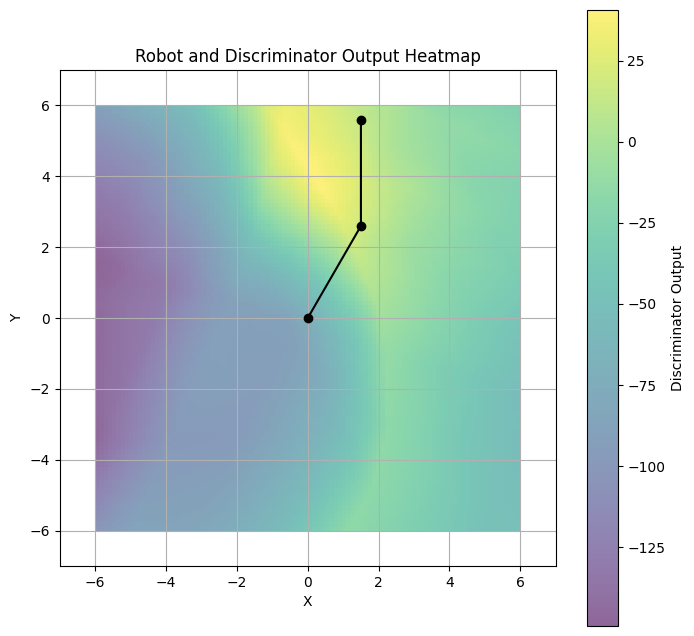

(np.float64(1.5707963267948961), np.float64(-0.523598775598298))


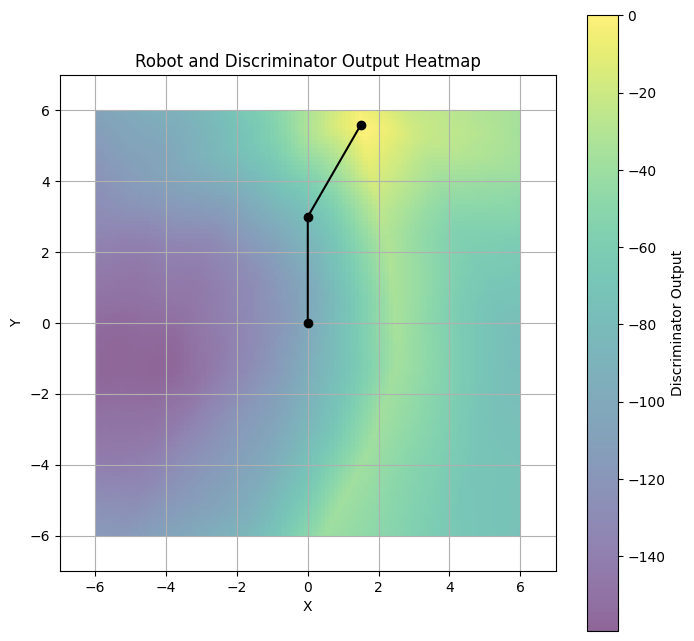

In [5]:
# Given angles
angles = (np.pi/3, np.pi/6)  # Example angles

# Plot the robot and heatmap
plot_robot_and_heatmap(robot, discriminator, angles)

# Calculate the conjugate angle such that the target is the same
conjugate_angles = robot.get_conjugate_angles(angles)
print(conjugate_angles)

plot_robot_and_heatmap(robot, discriminator, conjugate_angles)